# Predicting House Elections

- Initially wanted to predict district-by-district results using polling data
- Realized this was a much bigger project than I could take on right now
- Instead decided on using general ballot polling data 
- Since this data usually is very close, I added in campaign finance data, incumbency data, and data on who was the president
- Ran a logistic regression model on 2012 and 2014 elections, training and testing individually on each one, getting very good results
- Then trained the model on 2012 and 2014 elections together and used them to predict the 2016 house election
- Realized that because the results in general ballot polling data are usually so close to each other, this is not a very useful predictor of elections
- Rather, as Paul realized, campaign finance data is a fairly good predictor

In [52]:
%matplotlib inline

In [77]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# Load in polling data

In [32]:
#polling data
house_polls_2012 = pd.read_csv('data/final/12-US-House-poll-responses-clean.tsv', sep='\t', lineterminator='\n')
house_polls_2014 = pd.read_csv('data/final/14-US-House-poll-responses-clean.tsv', sep='\t', lineterminator='\n')


# Weight the polling data based on proximity to election

In [129]:
#weight the polling data based on proximity to election
election_2012_date = dt.datetime(2012, 11, 6)
election_2014_date = dt.datetime(2014, 11, 4)
house_polls_2012['end_date'] = pd.to_datetime(house_polls_2012['end_date'])
house_polls_2014['end_date'] = pd.to_datetime(house_polls_2014['end_date'])
house_polls_2012['days_from_election'] =(election_2012_date -  house_polls_2012['end_date'])
house_polls_2014['days_from_election'] =(election_2014_date -  house_polls_2014['end_date'])
house_polls_2012['days_from_election'] = house_polls_2012['days_from_election'].apply(lambda x: int(x.days))
max_num = house_polls_2012['days_from_election'].max()

house_polls_2014['days_from_election'] = house_polls_2014['days_from_election'].apply(lambda x: int(x.days))
max_num_2014 = house_polls_2014['days_from_election'].max()
house_polls_2012['days_from_election'] =max_num - house_polls_2012['days_from_election']

house_polls_2014['days_from_election'] =max_num_2014 - house_polls_2014['days_from_election']


house_polls_2012['democrat_weight'] = house_polls_2012['Democrat']*house_polls_2012['days_from_election']

house_polls_2014['democrat_weight'] = house_polls_2014['Democrat']*house_polls_2014['days_from_election']
house_polls_2012['republican_weight'] = house_polls_2012['Republican']*house_polls_2012['days_from_election']
house_polls_2014['republican_weight'] = house_polls_2014['Republican']*house_polls_2014['days_from_election']
house_polls_2012['democrat_avg'] = house_polls_2012['democrat_weight'].sum()/house_polls_2012['days_from_election'].sum()
house_polls_2014['democrat_avg'] = house_polls_2014['democrat_weight'].sum()/house_polls_2014['days_from_election'].sum()

house_polls_2012['republican_avg'] = house_polls_2012['republican_weight'].sum()/house_polls_2012['days_from_election'].sum()
house_polls_2014['republican_avg'] = house_polls_2014['republican_weight'].sum()/house_polls_2014['days_from_election'].sum()

# Load in election results

In [130]:
#load in election results
df_election_2012 = pd.read_excel('data/final/federalelections2012.xls', sheet_name=11)
df_election_2014 = pd.read_excel('data/final/federalelections2014.xls', sheet_name=7)
df_election_2016 = pd.read_excel('data/final/federalelections2016.xlsx', sheet_name=12)

# Clean election result data

In [131]:
df_election_2012 = df_election_2012[df_election_2012['FEC ID#'].str.contains("n/a") == False]
df_election_2014 = df_election_2014[df_election_2014['FEC ID#'].str.contains("n/a") == False]
df_election_2016 = df_election_2016[df_election_2016['FEC ID#'].str.contains("n/a") == False]

In [132]:
df_elections_cleaned = df_election_2012[['STATE ABBREVIATION', 'D', '(I)','FEC ID#', 'CANDIDATE NAME', 'GENERAL %', 'GE WINNER INDICATOR']]

In [133]:
df_elections_cleaned_2014 = df_election_2014[['STATE ABBREVIATION', 'D', '(I)','FEC ID#', 'CANDIDATE NAME', 'GENERAL %', 'GE WINNER INDICATOR']]


df_elections_cleaned_2016 = df_election_2016[['STATE ABBREVIATION', 'D', '(I)','FEC ID#', 'CANDIDATE NAME', 'GENERAL %', 'GE WINNER INDICATOR']]



# Load in fundraising data

In [134]:
raising_2012 = pd.read_csv('data/final/weball12.txt', sep='|', lineterminator='\n', header=None)
raising_2014 = pd.read_csv('data/final/weball14.txt', sep='|', lineterminator='\n', header=None)
raising_2016 = pd.read_csv('data/final/weball16.txt', sep='|', lineterminator='\n', header=None)



 # Label and clean data

In [135]:
cols = pd.read_excel('data/final/fundraising_mapping.xlsx', header=None)
col_list = cols[0].values.tolist()[0:30]

In [136]:
raising_2012.columns = col_list
raising_2014.columns = col_list
raising_2016.columns = col_list

In [137]:
raising_2012_subset = raising_2012[['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS']]
raising_2014_subset = raising_2014[['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS']]
raising_2016_subset = raising_2016[['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS']]

# Further clean and join data

In [138]:
df_election_2012_subset = df_election_2012[['STATE ABBREVIATION', '(I)','D', 'FEC ID#', 'CANDIDATE NAME (First)', 
                                           'CANDIDATE NAME (Last)', 'GENERAL %', 'GE WINNER INDICATOR', 'PARTY']]

df_election_2014_subset = df_election_2014[['STATE ABBREVIATION', '(I)','D', 'FEC ID#', 'CANDIDATE NAME (First)', 
                                           'CANDIDATE NAME (Last)', 'GENERAL %', 'GE WINNER INDICATOR', 'PARTY']]



df_election_2016_subset = df_election_2016[['STATE ABBREVIATION', '(I)','D', 'FEC ID#', 'CANDIDATE NAME (First)', 
                                           'CANDIDATE NAME (Last)', 'GENERAL %', 'GE WINNER INDICATOR', 'PARTY']]

In [139]:
df_election_2012_subset['CAND_ID'] = df_election_2012_subset['FEC ID#'].apply(lambda x:str(x).strip())
raising_2012_subset['CAND_ID'] = raising_2012_subset['CAND_ID'].apply(lambda x:str(x).strip())



df_election_2014_subset['CAND_ID'] = df_election_2014_subset['FEC ID#'].apply(lambda x:str(x).strip())
raising_2014_subset['CAND_ID'] = raising_2014_subset['CAND_ID'].apply(lambda x:str(x).strip())


df_election_2016_subset['CAND_ID'] = df_election_2016_subset['FEC ID#'].apply(lambda x:str(x).strip())
raising_2016_subset['CAND_ID'] = raising_2016_subset['CAND_ID'].apply(lambda x:str(x).strip())

/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [140]:
raising_2012_subset = raising_2012_subset.set_index('CAND_ID')
df_election_2012_subset = df_election_2012_subset.set_index('CAND_ID')
raising_2014_subset = raising_2014_subset.set_index('CAND_ID')
df_election_2014_subset = df_election_2014_subset.set_index('CAND_ID')
raising_2016_subset = raising_2016_subset.set_index('CAND_ID')
df_election_2016_subset = df_election_2016_subset.set_index('CAND_ID')

In [141]:
joined_data = df_election_2012_subset.join(raising_2012_subset, on='CAND_ID')
joined_data_2014 = df_election_2014_subset.join(raising_2014_subset, on='CAND_ID')

joined_data_2016 = df_election_2016_subset.join(raising_2016_subset, on='CAND_ID')

# Fix missing and null values

In [142]:
#can't match everybody, but don't think that's a huge issue
joined_data_2016[joined_data_2016['(I)'].notnull() & joined_data_2016['CAND_ICI'].isnull()]

,STATE ABBREVIATION,(I),D,FEC ID#,CANDIDATE NAME (First),CANDIDATE NAME (Last),GENERAL %,GE WINNER INDICATOR,PARTY,CAND_NAME,CAND_ICI,CAND_PTY_AFFILIATION,TTL_RECEIPTS
CAND_ID,,,,,,,,,,,,,
H6NE01119,NE,(I),01,H6NE01119,Daniel M.,Wik,0.305474,NaN,D,NaN,NaN,NaN,NaN
H4PA03117,PA,(I),03,H4PA03117,Mike,Kelly,0.972087,W,R,NaN,NaN,NaN,NaN
H6WA03234,WA,(I),03,H6WA03234,Jaime Herrera,Beutler,0.617527,W,R,NaN,NaN,NaN,NaN
H6WA05171,WA,(I),05,H6WA05171,Cathy McMorris,Rodgers,0.596410,W,R,NaN,NaN,NaN,NaN


In [143]:
joined_data.loc[joined_data.index=='H81D02064','CAND_ICI'] = 'I'
joined_data.loc[joined_data.index=='H6IA01055','CAND_ICI'] = 'I'
joined_data.loc[joined_data.index=='H8HY02031','CAND_ICI'] = 'I'
joined_data.loc[joined_data.index=='H8NE02129','CAND_ICI'] = 'I'
joined_data.loc[joined_data.index=='H8NE02129','CAND_ICI'] = 'I'
joined_data.loc[joined_data.index=='H6OH23033','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H8CA44034','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H8FL22038','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H81D02064','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H6IL02124','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H0IL15053','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H6IA01055','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H8HY02031','CAND_ICI'] = 'I'

joined_data_2014.loc[joined_data_2014.index=='H6MA07101','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='S0MA00109','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H0MI08042','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H2NJ04165','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H6OH23033','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H6PA04110','CAND_ICI'] = 'I'

joined_data_2014.loc[joined_data_2014.index=='H8NE02129','CAND_ICI'] = 'I'
joined_data_2014.loc[joined_data_2014.index=='H2PA06080','CAND_ICI'] = 'I'
joined_data_2016.loc[joined_data_2016.index=='H6NE01119','CAND_ICI'] = 'I'
joined_data_2016.loc[joined_data_2016.index=='H4PA03117','CAND_ICI'] = 'I'
joined_data_2016.loc[joined_data_2016.index=='H6WA03234','CAND_ICI'] = 'I'
joined_data_2016.loc[joined_data_2016.index=='H6WA05171','CAND_ICI'] = 'I'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f6c76d8>,
      dtype=object)

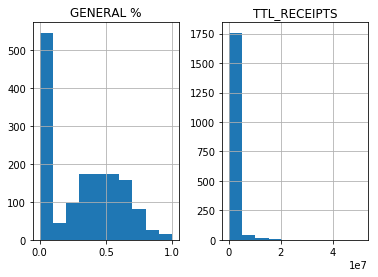

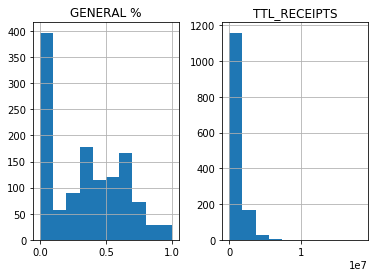

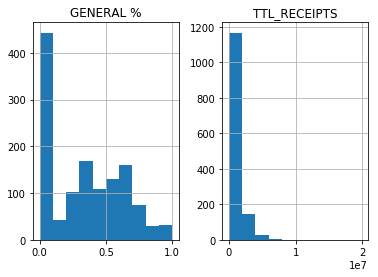

In [144]:

joined_data.hist()
joined_data_2014.hist()
joined_data_2016.hist()

# Use log of campaign contributions

In [145]:
joined_data_no_null = joined_data[joined_data['TTL_RECEIPTS'].notnull()]
joined_data_no_null['TTL_RECEIPTS'] = joined_data_no_null['TTL_RECEIPTS'].apply(lambda x: max(1, x))
joined_data_no_null['money_raised_log'] = joined_data_no_null['TTL_RECEIPTS'].apply(lambda x: np.log(x))


joined_data_no_null_2014 = joined_data_2014[joined_data_2014['TTL_RECEIPTS'].notnull()]
joined_data_no_null_2014['TTL_RECEIPTS'] = joined_data_no_null_2014['TTL_RECEIPTS'].apply(lambda x: max(1, x))
joined_data_no_null_2014['money_raised_log'] = joined_data_no_null_2014['TTL_RECEIPTS'].apply(lambda x: np.log(x))


joined_data_no_null_2016 = joined_data_2016[joined_data_2016['TTL_RECEIPTS'].notnull()]
joined_data_no_null_2016['TTL_RECEIPTS'] = joined_data_no_null_2016['TTL_RECEIPTS'].apply(lambda x: max(1, x))
joined_data_no_null_2016['money_raised_log'] = joined_data_no_null_2016['TTL_RECEIPTS'].apply(lambda x: np.log(x))

/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

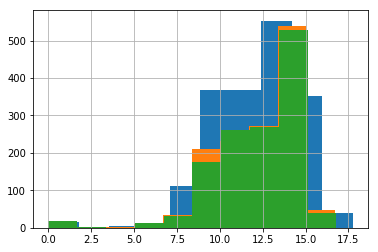

In [146]:

joined_data_no_null.money_raised_log.hist()
joined_data_no_null_2014.money_raised_log.hist()
joined_data_no_null_2016.money_raised_log.hist()

# Add some features

In [163]:
def winner_func(x):
    if x == 'W':
        return 1
    else:
        return 0
def incumbent_func(x):
    if x == 'I':
        return 1
    else:
        return 0
    
def party_match_pres(x):
    if x == 'D':
        return 1
    else:
        return 0

In [164]:
joined_data_no_null['win'] = joined_data_no_null['GE WINNER INDICATOR'].apply(lambda x: winner_func(x))
joined_data_no_null['incumbent'] = joined_data_no_null['CAND_ICI'].apply(lambda x: incumbent_func(x))


joined_data_no_null_2014['win'] = joined_data_no_null_2014['GE WINNER INDICATOR'].apply(lambda x: winner_func(x))
joined_data_no_null_2014['incumbent'] = joined_data_no_null_2014['CAND_ICI'].apply(lambda x: incumbent_func(x))

joined_data_no_null_2016['win'] = joined_data_no_null_2016['GE WINNER INDICATOR'].apply(lambda x: winner_func(x))
joined_data_no_null_2016['incumbent'] = joined_data_no_null_2016['CAND_ICI'].apply(lambda x: incumbent_func(x))

joined_data_no_null['party_match_pres'] = joined_data_no_null['PARTY'].apply(lambda x:party_match_pres(x))
joined_data_no_null_2014['party_match_pres'] = joined_data_no_null_2014['PARTY'].apply(lambda x:party_match_pres(x))
joined_data_no_null_2016['party_match_pres'] = joined_data_no_null_2016['PARTY'].apply(lambda x:party_match_pres(x))


/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [165]:
X_2012 = joined_data_no_null[['money_raised_log','incumbent', 'party_match_pres']]
y_2012 = joined_data_no_null['win']

X_2014 = joined_data_no_null_2014[['money_raised_log','incumbent','party_match_pres']]
y_2014 = joined_data_no_null_2014['win']

X_2016 = joined_data_no_null_2016[['money_raised_log','incumbent','party_match_pres']]
y_2016 = joined_data_no_null_2016['win']

# 2012 data

In [166]:
lr_2012 = LogisticRegression()

In [167]:
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y_2012)

In [168]:
lr_2012.fit(X_train_2012, y_train_2012)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [169]:
pred_2012 = lr_2012.predict(X_test_2012)

# 2012 Logistic Regression

In [200]:
lr_2012.score(X_test_2012, y_test_2012)

0.8971553610503282

In [201]:
print(classification_report(y_test_2012, pred_2012))

             precision    recall  f1-score   support

          0       0.94      0.92      0.93       325
          1       0.81      0.85      0.83       132

avg / total       0.90      0.90      0.90       457



# 2012 Dummy


In [172]:
dummy_2012 = DummyClassifier()

In [173]:
dummy_2012.fit(X_train_2012, y_train_2012)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [174]:
dummy_pred_2012 = dummy.predict(X_test_2012)

In [175]:
print(classification_report(y_test_2012, dummy_pred_2012))

             precision    recall  f1-score   support

          0       0.70      0.68      0.69       325
          1       0.26      0.28      0.27       132

avg / total       0.57      0.56      0.57       457



In [176]:
dummy.score(X_test_2012, y_test_2012)

0.5886214442013129

# Add in polling data

In [177]:
repub_poll = house_polls_2012.republican_avg.max()
dem_poll = house_polls_2012.democrat_avg.max()
repub_poll_2014 = house_polls_2014.republican_avg.max()
dem_poll_2014= house_polls_2014.democrat_avg.max()

In [211]:
def likelihood_2012(x):
    if x == "D":
        return dem_poll
    elif x == "R":
        return repub_poll
    else:
        return 0
    
def likelihood_2014(x):
    if x == "D":
        return dem_poll_2014
    elif x == "R":
        return repub_poll_2014
    else:
        return 0
def likelihood_2016(x):
    if x == "D":
        return 46.0
    elif x == "R":
        return 45.4
    else:
        return 0


In [212]:
joined_data_no_null['likelihood'] = joined_data_no_null.PARTY.apply(lambda x: likelihood_2012(x))
joined_data_no_null_2014['likelihood'] = joined_data_no_null_2014.PARTY.apply(lambda x: likelihood_2014(x))

/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/josephrmattis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [186]:
X = joined_data_no_null[['money_raised_log','incumbent', 'party_match_pres','likelihood']]
y = joined_data_no_null['win']
X_train, X_test, y_train, y_test = train_test_split(X, y)



In [187]:
lr_polls_2012 = LogisticRegression()

In [189]:
lr_polls_2012.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [192]:
pred = lr_polls_2012.predict(X_test)

In [193]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96       229
          1       0.99      0.86      0.92       111

avg / total       0.95      0.95      0.95       340



In [ ]:

X_2014 = joined_data_no_null_2014[['money_raised_log','incumbent', 'party_match_pres','likelihood']]
y_2014 = joined_data_no_null_2014['win']
X_train, X_test, y_train, y_test = train_test_split(X_2014, y_2014)

In [195]:
lr_polls_2014 = LogisticRegression()

In [196]:
lr_polls_2014.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [197]:
pred = lr_polls_2014.predict(X_test)

In [198]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       197
          1       0.97      0.91      0.94       143

avg / total       0.95      0.95      0.95       340



# Using 2012 and 2014 to predict 2016

In [203]:
X = joined_data_no_null[['money_raised_log','incumbent', 'party_match_pres','likelihood']]
y = joined_data_no_null['win']
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_2014 = joined_data_no_null_2014[['money_raised_log','incumbent', 'party_match_pres','likelihood']]
y_2014 = joined_data_no_null_2014['win']
X_train, X_test, y_train, y_test = train_test_split(X_2014, y_2014)

In [204]:
data_2012 = joined_data_no_null.reset_index()
data_2014 = joined_data_no_null_2014.reset_index()
data_2016 = joined_data_no_null_2016.reset_index()

In [205]:
joined_data_train = pd.concat([data_2012, data_2014])

In [213]:
data_2016['likelihood'] = data_2016.PARTY.apply(lambda x: likelihood_2016(x))

In [214]:
X_train = joined_data_train[['money_raised_log','incumbent', 'party_match_pres', 'likelihood']]
y_train = joined_data_train['win']
X_test = data_2016[['money_raised_log','incumbent', 'party_match_pres','likelihood']]
y_test = data_2016['win']

In [215]:
lr_final= LogisticRegression()

In [216]:
lr_final.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [217]:
pred = lr_final.predict(X_test)

In [218]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       851
          1       0.95      0.87      0.91       491

avg / total       0.94      0.94      0.94      1342



In [220]:
lr_final.score(X_test, y_test)

0.9359165424739195

In [222]:
data_2016['pred'] = pred

In [223]:
data_2016[data_2016['pred']==1].PARTY.value_counts()

R              212
D              166
WF              15
WEP             12
IDP              8
REF              7
CRV              7
DFL              5
W(IP)            4
R                3
D/IP             2
W(R)             2
R                1
R/TRP            1
R                1
D/R              1
D/PRO/WF/IP      1
R/IP             1
R/W              1
W(D)             1
Name: PARTY, dtype: int64